# A Building Controls OpenAI Gym Environment - 1st-Order Model Train Demo
**(C) Vasken Dermardiros**

Supplementary work to accompany "A Simplied Building Controls Environment with a Reinforcement Learning Application" paper submitted to IBPSA Rome 2019 Conference. Paper authors: Vasken Dermardiros, Scott Bucking and Andreas K. Athienitis.

Please consult the following links to be more accustomed to how OpenAI Gym and Tensorforce work:
+ OpenAI Documentation: https://gym.openai.com/docs
+ Creating a new OpenAI Env: https://github.com/openai/gym/tree/master/gym/envs#how-to-create-new-environments-for-gym
+ OpenAI Env Wiki: https://github.com/openai/gym/wiki/Environments
+ Simple example: https://github.com/MartinThoma/banana-gym
+ OpenAI Baselines: https://github.com/openai/baselines
+ Tensorforce: https://github.com/tensorforce/tensorforce

Other info:
+ MuJoCo: https://www.roboti.us/index.html
+ https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/
+ https://python-packaging.readthedocs.io/en/latest/minimal.html
+ https://ray.readthedocs.io/en/latest/rllib.html
+ https://github.com/ray-project/ray/tree/master/python/ray/rllib


To install, go to gym-BuildingControls folder and run the command:

    pip install -e .

In [1]:
# Make notebook full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Import Dependencies

In [2]:
# from /tensorforce/examples/quickstart.py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

from tensorforce.core.preprocessors import Preprocessor
from tensorforce.execution import Runner
from tensorforce.contrib.openai_gym import OpenAIGym

# Create an OpenAIgym environment.
import gym
from gym import wrappers
import gym_BuildingControls
environment = OpenAIGym('BuildingControls-v0', visualize=False) # tensorforce
env_gym = gym.make('BuildingControls-v0') # openai gym
cumsum_curriculum = np.cumsum(env_gym.curriculum)

import os
if os.name == 'nt':      save_dir = 'C:/RLAgentSaved/'
elif os.name == 'posix': save_dir = '/home/vasken/RLAgentSaved/'
restore = False    
save_interval = 1e10 #int(episodes/10.)
report_interval = 500
plot_interval = 1e10 # XXX: Don't use
plot_test_interval = 1e10 # XXX: Don't use

C:\Users\Vasken\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Building: 0, 1st-order model.
Loaded perturbations.
Perturbation mode: 0
Settings mode: 0
Building: 0, 1st-order model.
Loaded perturbations.
Perturbation mode: 0
Settings mode: 0


In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'figure.subplot.left': 0.15, 'figure.subplot.bottom': 0.19})

## User-defined classes and functions

In [4]:
# Following are controller classes
class agent_constant():
    def __init__(self, constant_action):
        self.action = constant_action
    def act(self, s, deterministic=True):
        return self.action

class agent_random():
    def __init__(self, nA):
        self.nA = nA
    def act(self, s, deterministic=True):
        return np.random.choice(self.nA)
    
class agent_bangbang():
    """ One stage bang-bang controls"""
    def __init__(self, hvac_levels, heat_on, heat_off, cool_on, cool_off, hvac_off=None):
        self.hvac_levels = hvac_levels
        self.heat_on, self.heat_off = heat_on, heat_off
        self.cool_on, self.cool_off = cool_on, cool_off
        self.hvac_off = (self.hvac_levels-1)/2. if (hvac_off == None) else hvac_off
    def act(self, s, deterministic=True):
        T = s[0]          # room sensor temp
        hvac_state = s[1] # hvac state
        self.action = 1   # default action: don't change hvac state/setting
        if (T < self.heat_on) and (hvac_state == self.hvac_off): self.action = 2 # turn on heating
        if (T > self.heat_off) and (hvac_state > self.hvac_off): self.action = 0 # turn off heating
        if (T > self.cool_on) and (hvac_state == self.hvac_off): self.action = 0 # turn on cooling
        if (T < self.cool_off) and (hvac_state < self.hvac_off): self.action = 2 # turn off cooling
        return self.action 
    
class agent_bangbang_2stage():
    """ Two stage bang-bang controls for heating only """
    def __init__(self, hvac_levels, heat_on, heat_off, heat_on_stage2, heat_off_stage2, hvac_off=None):
        self.hvac_levels = hvac_levels
        self.heat_on, self.heat_off = heat_on, heat_off
        self.heat_on_stage2, self.heat_off_stage2 = heat_on_stage2, heat_off_stage2
        self.hvac_off = (self.hvac_levels-1)/2. if (hvac_off == None) else hvac_off
    def act(self, s, deterministic=True):
        T = s[0]          # room sensor temp
        hvac_state = s[1] # hvac state
        self.action = 1   # default action: don't change hvac state/setting
        if (T < self.heat_on) and (hvac_state == self.hvac_off): self.action = 2 # turn on heating
        if (T > self.heat_off) and (hvac_state > self.hvac_off): self.action = 0 # turn off heating
        if (T < self.heat_on_stage2): self.action = 2 # turn on heating more
        if (T > self.heat_off_stage2) and (hvac_state > self.hvac_off): self.action = 0 # turn off stage 2 heating
        return self.action 

class agent_pi():
    """ Proportional-integral control with discrete mode output """
    def __init__(self, Kp, Ki, setpoint, hvac_off, mode='heating', output_deadband=500.):
        self.Kp, self.Ki, self.setpoint = Kp, Ki, setpoint
        self.hvac_off = hvac_off
        self.mode = mode
        self.out_db = output_deadband
        self.cum_error = 0
    def act(self, s, deterministic=True):
        T = s[0]          # room sensor temp (process variable)
        hvac_state = s[1] # hvac state
        self.action = 1   # default action: don't change hvac state/setting
        error = self.setpoint - T # setpoint error
        self.cum_error += error   # cumulative error
        output = self.Kp*error + self.Ki*self.cum_error # PI raw output
        if self.mode == 'heating':
            # TODO make this part generic/general
            if (output <= 2500-self.out_db) & (hvac_state > self.hvac_off): self.action = 0 # turn off heating (hvac setting 1, off)
            if (output >  2500+self.out_db) & (hvac_state <= self.hvac_off): self.action = 2 # turn on heating (hvac setting 2)
            if (output <= 7500-self.out_db) & (hvac_state >  2): self.action = 0 # turn down heating (hvac setting 2)
            if (output >  7500+self.out_db) & (hvac_state <= 2): self.action = 2 # turn up heating (hvac setting 3)
        elif self.mode == 'cooling':
            # TODO make this part generic/general
            if (output >  -1500+self.out_db) & (hvac_state < self.hvac_off): self.action = 2 # turn off cooling (hvac setting 1, off)
            if (output <= -1500-self.out_db) & (hvac_state >= self.hvac_off): self.action = 0 # turn on cooling (hvac setting 0)            
        return self.action 

# Function to plot results    
def show_results(agent, perturbation_mode, plot_progression=True, reward_limit=None, plot_T=False, save_prefix=""):
    figsize=(10,3)
    figext, figdpi = ".png", 300
    tickhrs = 12

    # env_gym = gym.make('BuildingControls-v0') # openai gym
    env_gym.perturbation_mode = perturbation_mode
    env_gym.change_perturbations_mode()
    
    s = env_gym.reset()
    done = False
    obs_history = s[0] # only track index 0 state observation = room temperature
    hvac_history = s[1] # hvac state [0,1,2,3,4]
    act_history = np.array([]) # actions taken -/0/+
    Tamb_history = s[15] # ambient temp
    T_history = np.empty(env_gym.nN) # all temperatures; agent does not see this, read from "info" variable passed @ env.step()
    reward_history = np.array([]) # actions taken -/0/+

    while not done:
        # env.render()
        action = agent.act(s, deterministic=True)
        # s, done, r = environment.execute(action)
        s, r, done, info = env_gym.step(action)

        obs_history = np.append(obs_history, s[0])
        hvac_history = np.append(hvac_history, s[1])
        act_history = np.append(act_history, action-1)
        Tamb_history = np.append(Tamb_history, s[15])
        T_history = np.vstack((T_history, info['T']))
        reward_history = np.append(reward_history, r)
        
    # llm, lsp, hsp, hlm = env_gym.T_low_limit, env_gym.T_low_sp, env_gym.T_high_sp, env_gym.T_high_limit # setpoint limits
    lsp, hsp = env_gym.T_low_sp, env_gym.T_high_sp # setpoint limits
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    plt.plot(obs_history, 'k')
    if plot_T: plt.plot(T_history, '--')
    plt.xlim((0,env_gym.nT))
    ax.set_xticks(np.arange(0,env_gym.nT+1,4*tickhrs))
    ax.set_xticklabels(np.arange(0,int(env_gym.nT/4)+1,tickhrs))
    ax.set_yticks([lsp, hsp])    
    plt.xlabel('Time, h')
    plt.ylabel('Temperature, degC')
    # plt.ylim()
    # plt.plot(np.full(env_gym.nT, hlm), 'b')
    plt.plot(np.full(env_gym.nT, hsp), 'b--')
    plt.plot(np.full(env_gym.nT, lsp), 'r--')
    # plt.plot(np.full(env_gym.nT, llm), 'r')
    if save_prefix: plt.savefig(save_prefix+'_Temp'+figext, dpi=figdpi)
    plt.show()
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    plt.plot(hvac_history)
    # plt.title("HVAC State")
    plt.xlim((0,env_gym.nT))
    plt.ylim((env_gym.minA,env_gym.maxA))
    ax.set_yticks(np.arange(env_gym.maxA+1))
    ax.set_yticklabels(np.arange(env_gym.maxA+1))
    ax.set_xticks(np.arange(0,env_gym.nT+1,4*tickhrs))
    ax.set_xticklabels(np.arange(0,int(env_gym.nT/4)+1,tickhrs))
    plt.xlabel('Time, h')
    plt.ylabel('HVAC State')
    if save_prefix: plt.savefig(save_prefix+'_HVAC'+figext, dpi=figdpi)
    plt.show()
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)    
    plt.plot(act_history)
    plt.xlim((0,env_gym.nT))  
    # plt.title("Action")
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels(["↓","","↑"])
    plt.yticks(fontsize=20)
    ax.set_xticks(np.arange(0,env_gym.nT+1,4*tickhrs))
    ax.set_xticklabels(np.arange(0,int(env_gym.nT/4)+1,tickhrs))
    plt.xlabel('Time, h')
    plt.ylabel('Action')
    if save_prefix: plt.savefig(save_prefix+'_Action'+figext, dpi=figdpi)
    plt.show()
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)    
    plt.plot(Tamb_history)
    plt.xlim((0,env_gym.nT))
    # plt.title("T_ambient")
    ax.set_xticks(np.arange(0,env_gym.nT+1,4*tickhrs))
    ax.set_xticklabels(np.arange(0,int(env_gym.nT/4)+1,tickhrs))
    plt.xlabel('Time, h')
    plt.ylabel('T_ambient, degC')
    if save_prefix: plt.savefig(save_prefix+'_TAmbient'+figext, dpi=figdpi)
    plt.show()
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)    
    plt.plot(reward_history)
    plt.xlim((0,env_gym.nT))
    # plt.title("Reward in episode")
    ax.set_xticks(np.arange(0,env_gym.nT+1,4*tickhrs))
    ax.set_xticklabels(np.arange(0,int(env_gym.nT/4)+1,tickhrs))
    plt.xlabel('Time, h')
    plt.ylabel('Step Reward')
    if save_prefix: plt.savefig(save_prefix+'_StepReward'+figext, dpi=figdpi)
    plt.show()
        
    reward_cumulative = np.cumsum(reward_history)
    print("End reward: %.1f" % reward_cumulative[-1])
    # plt.figure()
    # plt.plot(reward_cumulative)
    # plt.title("Cumulative reward in episode")

    if plot_progression:
        # Training progression
        # plt.figure(figsize=figsize)
        # plt.plot(runner.episode_timesteps, marker='.', linestyle='None', alpha=0.1)
        # plt.title("Timesteps")
        plt.figure(figsize=figsize)
        plt.plot(runner.episode_rewards, marker='.', linestyle='None', alpha=0.1)
        if reward_limit != None:
            plt.ylim((reward_limit, 0))
        plt.xlabel('Episode')
        plt.title("Rewards")
        if save_prefix: plt.savefig(save_prefix+'_RLTrainRewardEpisodic'+figext, dpi=figdpi)
        plt.show()        
        
# Callback function printing episode statistics
def episode_finished(r):
    message = "Finished episode {ep} after {ts} timesteps (reward: {reward})".format(ep=r.episode, ts=r.episode_timestep, reward=int(r.episode_rewards[-1]))
    pbar.set_description(message)
    pbar.update(1)
    
    if (r.episode % save_interval == 0) and (r.episode != 0):
        # print("Model save checkpoint.")
        r.agent.save_model(directory=save_dir, append_timestep=True)
        # r.agent.save_model()
    if (r.episode % report_interval == 0) and (r.episode != 0):      
        print("Average of last 500 rewards: {}".format(np.mean(r.episode_rewards[-500:])))
        print("Average of last 100 rewards: {}".format(np.mean(r.episode_rewards[-100:])))
        print("Best 5 of last 100 rewards: {}".format(np.sort(r.episode_rewards[-100:])[-5::]))
    if (r.episode % plot_interval == 0) and (r.episode != 0):      
        mode = np.searchsorted(cumsum_curriculum, r.episode)
        print("Mode: %i" % mode)
        show_results(agent, perturbation_mode=mode)
    if (r.episode % plot_test_interval == 0) and (r.episode != 0):        
        show_results(agent, perturbation_mode=8, plot_progression=False, save_prefix="RLHeat_%i" % r.episode)
        show_results(agent, perturbation_mode=9, plot_progression=False, save_prefix="RLCool_%i" % r.episode)        
    return True

# Function to create RL agent given type and network architecture
def create_agent(network='dense_lstm', flavour='quickstart_custom_net'):
    # neural network "brain"
    if (network=='dense_lstm'):
        network_spec = [
            dict(type='dense', size=64),            
            dict(type='internal_lstm', size=64),
        ]
    elif (network=='dense_2'):
        network_spec = [
            dict(type='dense', size=64),            
            dict(type='dense', size=64),
        ]       
    elif (network=='dense_3'):
        network_spec = [
            dict(type='dense', size=64),
            dict(type='dense', size=64),            
            dict(type='dense', size=64),
        ]                  
    else:
        print("Unknown network input!")
        
    # create the agent
    if (flavour=='quickstart_custom_net'):
        from tensorforce.agents import PPOAgent
        """ https://github.com/reinforceio/tensorforce/blob/master/examples/quickstart.py """
        agent = PPOAgent(
            states=environment.states,
            actions=environment.actions,
            network=network_spec,
            # Agent
            states_preprocessing=None, #preprocessing_config,
            actions_exploration='epsilon_decay', #None,
            reward_preprocessing=None,
            # MemoryModel
            update_mode=dict(
                unit='episodes',
                batch_size=10, # 10 episodes per update
                frequency=10, # Every 10 episodes
            ),
            memory=dict(
                type='latest',
                include_next_states=False,
                capacity=1000
            ),
            # DistributionModel
            distributions=None,
            entropy_regularization=0.01,
            # PGModel
            baseline_mode='states',
            baseline=dict(
                type='mlp',
                sizes=[64, 64]
            ),
            baseline_optimizer=dict(
                type='multi_step',
                optimizer=dict(
                    type='adam',
                    learning_rate=1e-3
                ),
                num_steps=20
            ),
            gae_lambda=0.99,
            # PGLRModel
            likelihood_ratio_clipping=0.2,
            # PPOAgent
            step_optimizer=dict(
                type='adam',
                learning_rate=1e-3
            ),
            subsampling_fraction=0.2,
            optimization_steps=25,
            execution=dict(
                type='single',
                session_config=None,
                distributed_spec=None
            )
        )
    elif (flavour=='vpg'):
        from tensorforce.agents import VPGAgent
        agent = VPGAgent(
            states=environment.states,
            actions=environment.actions, 
            network=network_spec, 
            batched_observe=False, 
            #batching_capacity=10, 
            scope='vpg', 
            execution=None, 
            variable_noise=None, 
            states_preprocessing=None, 
            actions_exploration='epsilon_decay', 
            reward_preprocessing=None, 
            update_mode=None, 
            memory=None, 
            optimizer={'type':'adam', 'learning_rate':1e-3}, 
            discount=0.99, 
            # distributions=None, 
            # entropy_regularization=None,
            # baseline_mode='states', 
            # baseline={'type':'mlp', 'sizes':[32, 32]},
            # baseline_optimizer={'type':'adam', 'learning_rate':1e-3}, 
            # gae_lambda=None,
        )        
    else:
        print("Unknown agent flavour input!")
        
    return agent

## Create the RL PPO Agent

In [5]:
# agent = create_agent(flavour='vpg', network='dense_2')
agent = create_agent(flavour='quickstart_custom_net', network='dense_lstm')
# agent = create_agent(flavour='quickstart_custom_net', network='dense_2')
# agent = create_agent(flavour='quickstart_custom_net', network='dense_3')
if restore: agent.restore_model(directory=save_dir)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


## Train

In [6]:
episodes = int(2500)
runner = Runner(agent=agent, environment=environment)
with tqdm(total=episodes) as pbar: runner.run(episodes=episodes, max_episode_timesteps=None, episode_finished=episode_finished)

Finished episode 50 after 179 timesteps (reward: -318):   2%|▍                       | 50/2500 [00:07<05:48,  7.03it/s]

Completed lesson. Incrementing perturbation mode.
Loaded perturbations.
Perturbation mode: 1


Finished episode 101 after 179 timesteps (reward: -93):   4%|▉                      | 101/2500 [00:14<05:22,  7.44it/s]

Completed lesson. Incrementing perturbation mode.
Loaded perturbations.
Perturbation mode: 2


Finished episode 152 after 359 timesteps (reward: -2551):   6%|█▎                   | 152/2500 [00:26<09:36,  4.08it/s]

Completed lesson. Incrementing perturbation mode.
Loaded perturbations.
Perturbation mode: 3


Finished episode 203 after 359 timesteps (reward: -1463):   8%|█▋                   | 203/2500 [00:39<09:43,  3.94it/s]

Completed lesson. Incrementing perturbation mode.
Loaded perturbations.
Perturbation mode: 4


Finished episode 304 after 95 timesteps (reward: -88):  12%|██▉                     | 304/2500 [00:47<02:35, 14.15it/s]

Completed lesson. Incrementing perturbation mode.
Loaded perturbations.
Perturbation mode: 5


Finished episode 500 after 95 timesteps (reward: -69):  20%|████▊                   | 500/2500 [01:01<02:36, 12.78it/s]

Average of last 500 rewards: -506.1418433523354
Average of last 100 rewards: -105.95524013079137
Best 5 of last 100 rewards: [-45.29933358 -45.0379237  -39.56976758 -39.38061049 -36.80618124]


Finished episode 805 after 95 timesteps (reward: -48):  32%|███████▋                | 804/2500 [01:24<02:02, 13.89it/s]

Completed lesson. Incrementing perturbation mode.
Loaded perturbations.
Perturbation mode: 6


Finished episode 1000 after 191 timesteps (reward: -324):  40%|████████            | 1000/2500 [01:50<04:00,  6.24it/s]

Average of last 500 rewards: -87.21189455288453
Average of last 100 rewards: -123.23936511500148
Best 5 of last 100 rewards: [-84.16989483 -84.10543132 -82.42672332 -81.27466795 -79.96173792]


Finished episode 1500 after 191 timesteps (reward: -79):  60%|████████████▌        | 1500/2500 [02:59<02:37,  6.34it/s]

Average of last 500 rewards: -119.24070094611078
Average of last 100 rewards: -106.51087078669609
Best 5 of last 100 rewards: [-73.11303113 -72.68689707 -72.57502024 -71.99978193 -68.74435869]


Finished episode 1806 after 191 timesteps (reward: -110):  72%|██████████████▍     | 1806/2500 [03:41<01:32,  7.49it/s]

Completed lesson. Incrementing perturbation mode.
Loaded perturbations.
Perturbation mode: 7


Finished episode 2000 after 575 timesteps (reward: -366):  80%|████████████████    | 2000/2500 [04:32<02:36,  3.20it/s]

Average of last 500 rewards: -197.6907254343864
Average of last 100 rewards: -273.4390659182012
Best 5 of last 100 rewards: [-102.928072    -92.54054582  -90.52293676  -86.65849426  -84.09490816]


Finished episode 2500 after 383 timesteps (reward: -235): 100%|████████████████████| 2500/2500 [06:31<00:00,  3.66it/s]

Average of last 500 rewards: -226.48692023402901
Average of last 100 rewards: -255.39771408245372
Best 5 of last 100 rewards: [-81.80867616 -81.46578365 -80.64105114 -76.07329282 -73.24405896]


## Define Baseline Controls

In [7]:
# agent_cnst = agent_constant(constant_action=1)
# agent_rand = agent_random(env_gym.nA)
agent_bang = agent_bangbang(hvac_levels=len(env_gym.heat_cool_levels), heat_on=20.5, heat_off=21.5, cool_on=25, cool_off=23.5, hvac_off=env_gym.heat_cool_off)
agent_bang2 = agent_bangbang_2stage(hvac_levels=len(env_gym.heat_cool_levels), heat_on=20.5, heat_off=21.5, heat_on_stage2=19, heat_off_stage2=21, hvac_off=env_gym.heat_cool_off)
agent_piheat = agent_pi(Kp=5000., Ki=20., setpoint=21., hvac_off=env_gym.heat_cool_off, mode='heating', output_deadband=2000.)
agent_picool = agent_pi(Kp=3000., Ki=10., setpoint=24., hvac_off=env_gym.heat_cool_off, mode='cooling', output_deadband=1000.)

## Heating Mode Test

In [8]:
perturbation_mode = 10

In [9]:
# print('Constant Agent')
# show_results(agent_cnst, perturbation_mode, plot_progression=False,)# plot_T=True)

In [10]:
# print('Random Agent')
# show_results(agent_rand, perturbation_mode, plot_progression=False)

BangBang Agent 2 stage
Loaded perturbations.
Perturbation mode: 10


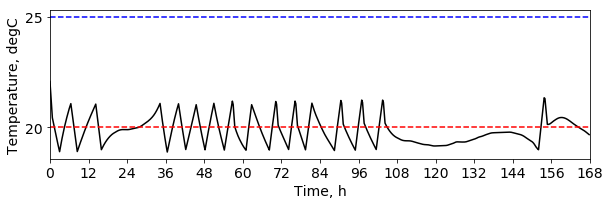

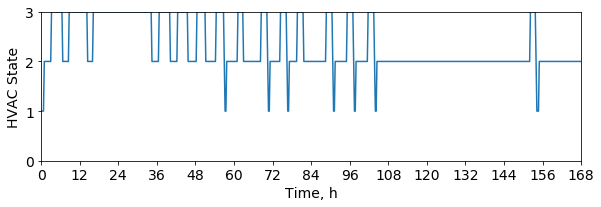

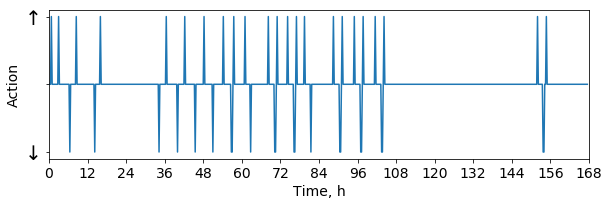

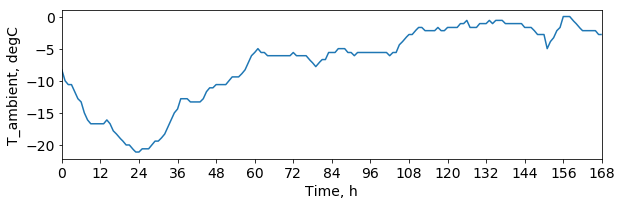

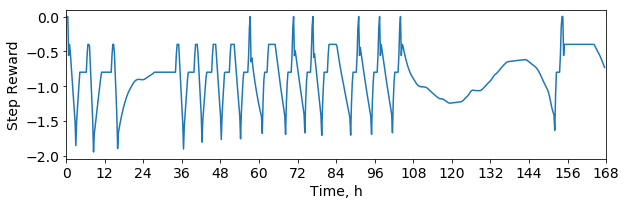

End reward: -575.9


In [11]:
print('BangBang Agent 2 stage')
show_results(agent_bang2, perturbation_mode, plot_progression=False, save_prefix="BangBangHeat")

Proportional-Integral Agent: Heating Mode
Loaded perturbations.
Perturbation mode: 10


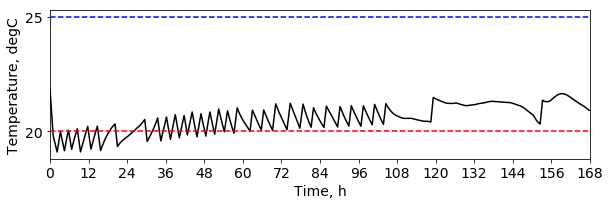

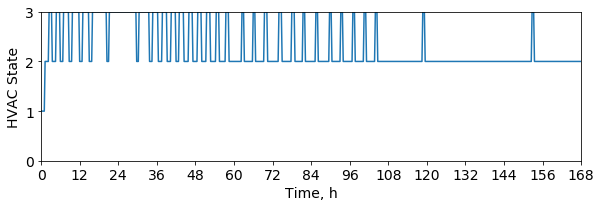

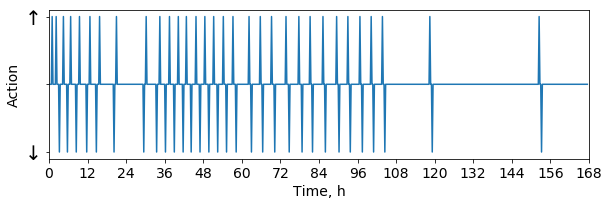

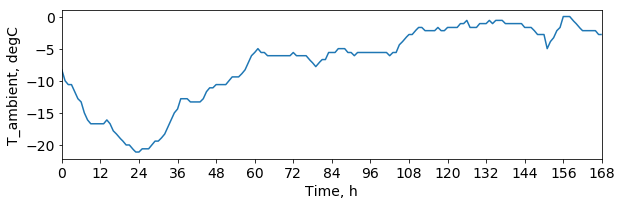

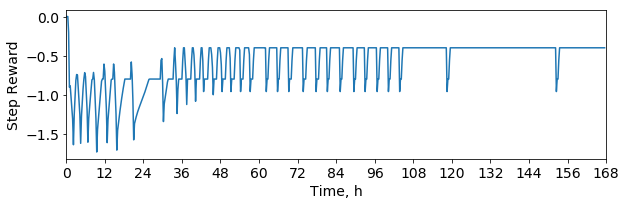

End reward: -392.2


In [12]:
print('Proportional-Integral Agent: Heating Mode')
agent_piheat.cum_error = 0 # reset error
show_results(agent_piheat, perturbation_mode, plot_progression=False, save_prefix="PIHeat")

RL Agent
Loaded perturbations.
Perturbation mode: 10


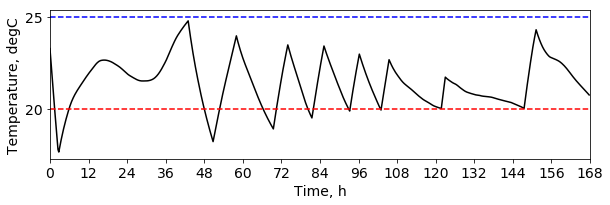

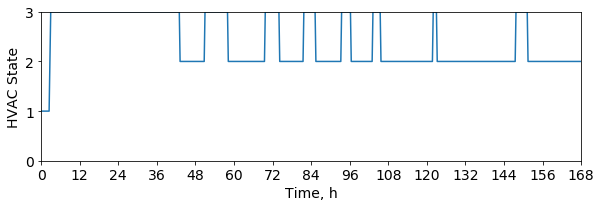

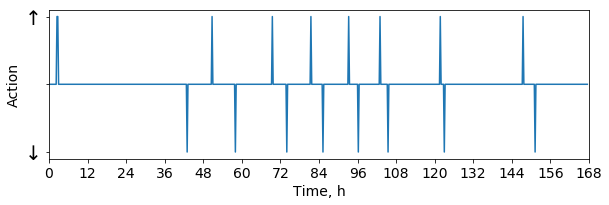

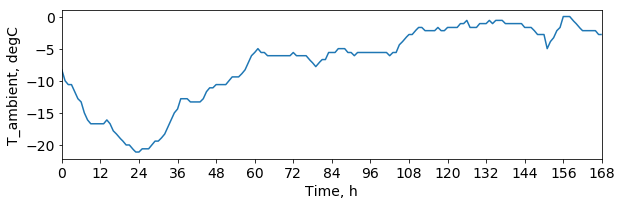

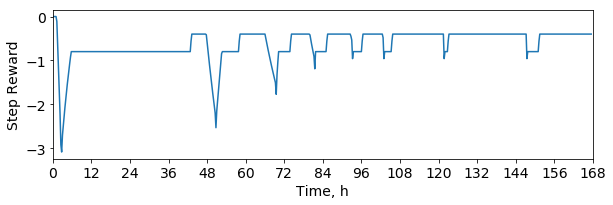

End reward: -423.4


In [13]:
print('RL Agent')
show_results(agent, perturbation_mode, plot_progression=False, save_prefix="RLHeat") # plot_T=True)
# show_results(agent, perturbation_mode, plot_progression=False, save_prefix="RLHeat", plot_T=True)

## Cooling Mode Test

In [14]:
perturbation_mode = 11

BangBang Agent
Loaded perturbations.
Perturbation mode: 11


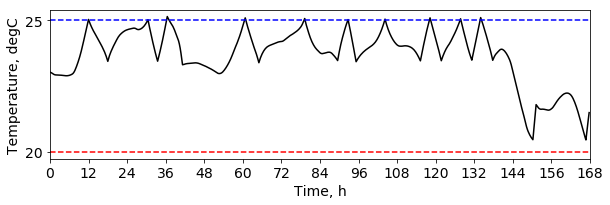

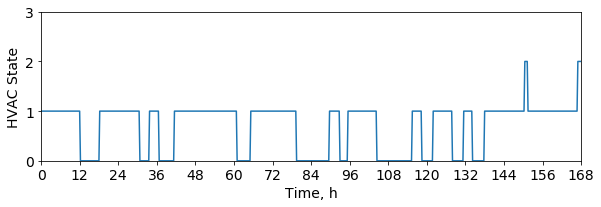

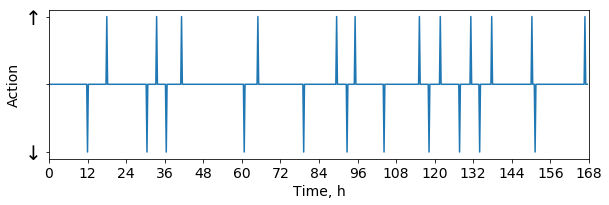

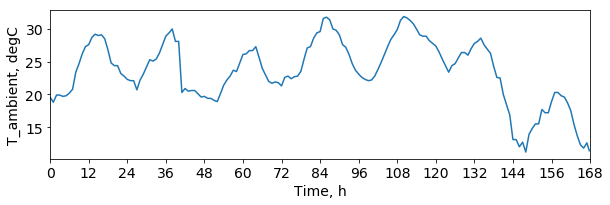

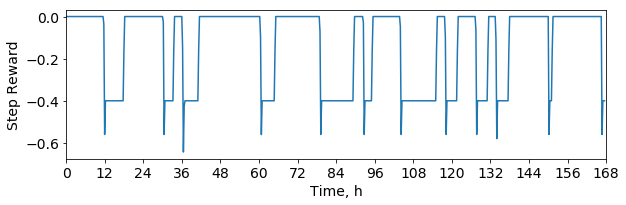

End reward: -91.7


In [15]:
print('BangBang Agent')
show_results(agent_bang, perturbation_mode, plot_progression=False, save_prefix="BangBangCool")

Proportional-Integral Agent: Cooling Mode
Loaded perturbations.
Perturbation mode: 11


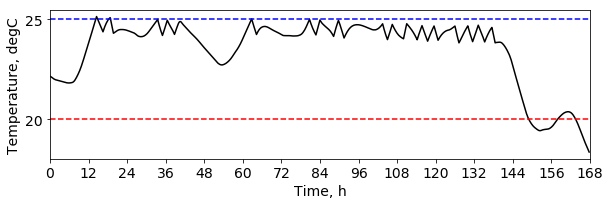

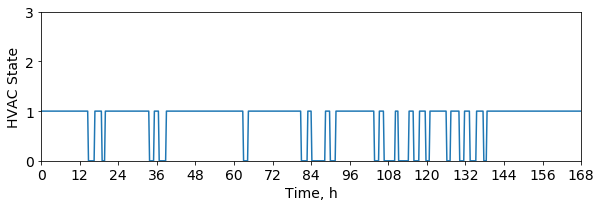

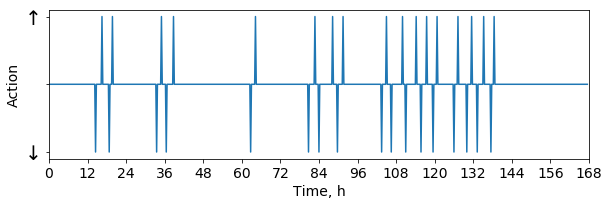

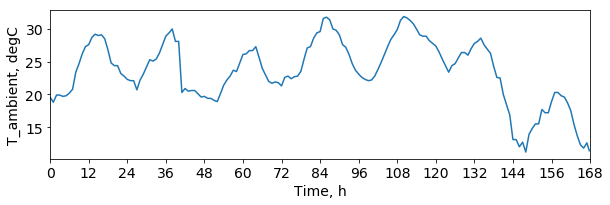

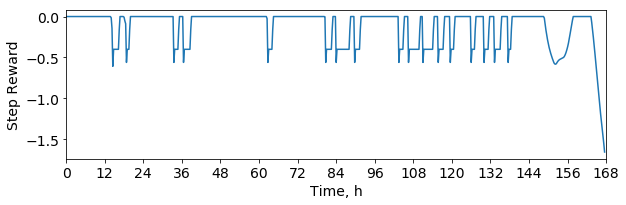

End reward: -88.0


In [16]:
print('Proportional-Integral Agent: Cooling Mode')
agent_picool.cum_error = 0 # reset error
show_results(agent_picool, perturbation_mode, plot_progression=False, save_prefix="PICool")

RL Agent
Loaded perturbations.
Perturbation mode: 11


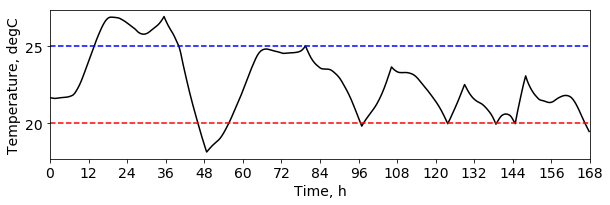

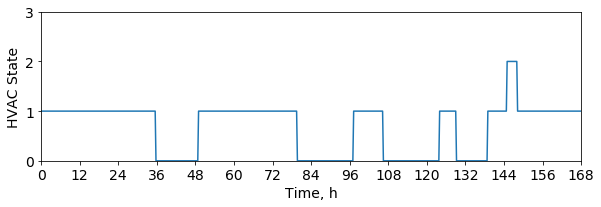

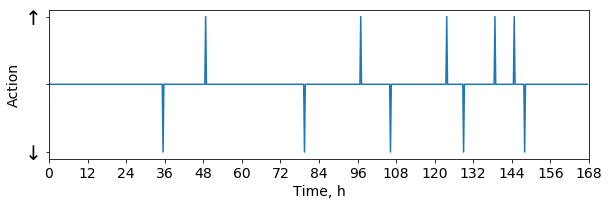

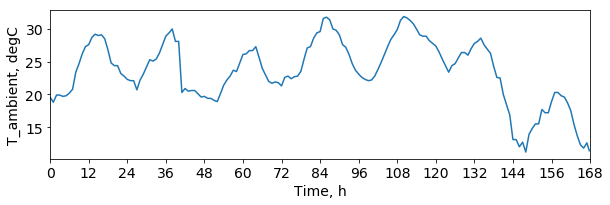

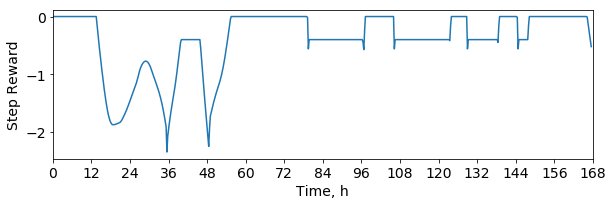

End reward: -271.3


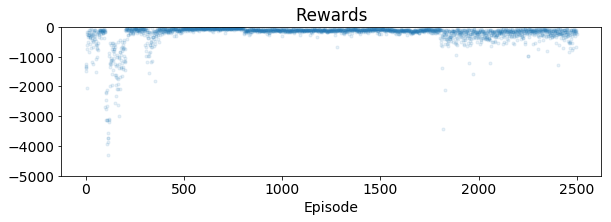

In [17]:
print('RL Agent')
show_results(agent, perturbation_mode, reward_limit=-5000., save_prefix="RLCool") # plot_T=True)
# show_results(agent, perturbation_mode, reward_limit=-5000., save_prefix="RLCool", plot_T=True)